In [1]:
from mimic.utilities import *
from mimic.utilities.utilities import plot_CRM, plot_CRM_with_intervals

from mimic.model_infer.infer_CRM_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_CRM import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

from scipy import stats
from scipy.integrate import odeint


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Bayesian inference to infer the parameters of a Consumer Resource model

The Consumer Resource equation based on the MacArthur model takes the form

$$
dN_i = \frac{N_i}{\tau} \cdot \left( c_{ij} \cdot (w \cdot R)_j - m_i \right)
$$

$$
dR_j = \frac{1}{r \cdot K_j} \cdot (K_j - R_j) \cdot R_j - (N_i \cdot c_{ij} \cdot R_j)
$$


where:
-   $N$ is the concentration of each species
-   $\tau$ is the species timescale
-   $m$ is the species mortality rate
-   $R$ is the concentration of each resource
-   $r$ is the resource timescale
-   $w$ is the quality of each resource
-   $K$ is the resource capacity
-   $c$ is each species' preference for each resource



Unlike the gLV, the CRM is not linearised, so the DifferentialEquation function from pymc is utilised to solve the ODEs within the inference function. This can take a while if inferring all parameters, so below we demonstrate two features of the run_inference: inferring only one parameter (c) while the rest remain fixed, and inferring all parameters, although this takes longer.

## Read in simulated data
The data was simulated examples-sim-CRM.ipynb

In [2]:
with open("params-s2-r2.pkl", "rb") as f:
    params = pickle.load(f)
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]
c = params["c"]

# read in the data

data = pd.read_csv("data-s2-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:6].values

## Infer parameter c only
While parameters tau, m, r, w and K remain fixed to true values generated by the simulation

times shape: (100,)
yobs shape: (100, 4)
Number of species: 2
Number of resources: 2
tau_hat is fixed
w_hat is fixed
c_hat is inferred
m_hat is fixed
r_hat is fixed
K_hat is fixed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_hat_vals]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+00


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+00   r2 =                  NaN


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1289 seconds.


Parameter tau_hat not found in posterior samples, skipping plot.
Parameter w_hat not found in posterior samples, skipping plot.
Plotting posterior for c_hat


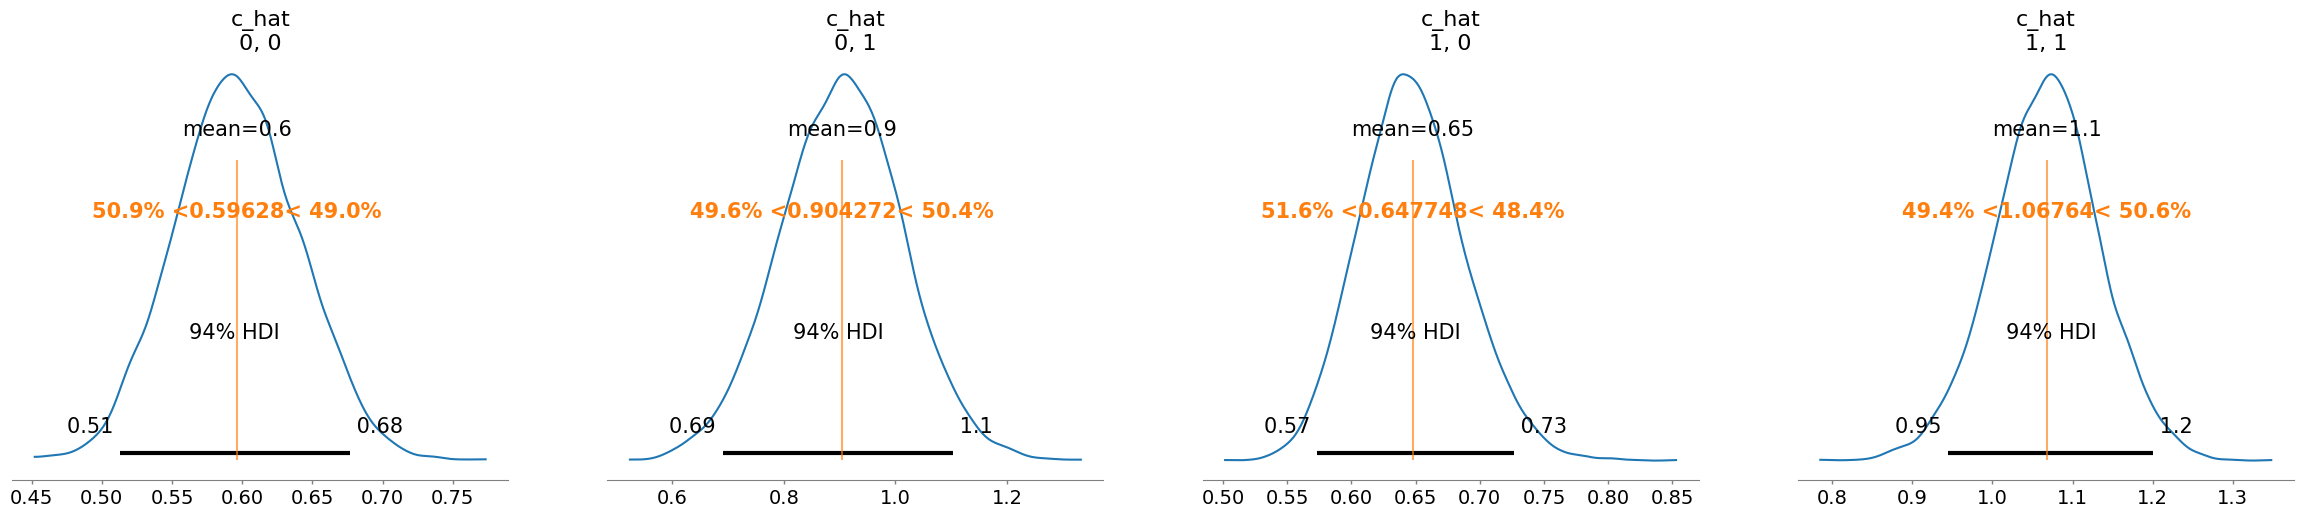

Parameter m_hat not found in posterior samples, skipping plot.
Parameter r_hat not found in posterior samples, skipping plot.
Parameter K_hat not found in posterior samples, skipping plot.
              mean     sd  r_hat
c_hat[0, 0]  0.596  0.044    1.0
c_hat[0, 1]  0.904  0.110    1.0
c_hat[1, 0]  0.648  0.041    1.0
c_hat[1, 1]  1.068  0.067    1.0
sigma[0]     2.841  0.094    1.0


'model_posterior.nc'

In [11]:
num_species = 2
num_resources = 2

# fixed parameters
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]

# Define prior for c (resource preference matrix)
prior_c_mean = 0.6
prior_c_sigma = 0.1

# Sampling conditions
draws = 2000
tune = 2000
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                         tau=tau, m=m, r=r, w=w, K=K,
                         prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                         draws=draws, tune=tune, chains=chains, cores=cores)

idata = inference.run_inference()

# To plot posterior distributions
inference.plot_posterior(idata)


summary = az.summary(idata, var_names=["c_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



array([[<Axes: title={'center': 'c_hat'}>,
        <Axes: title={'center': 'c_hat'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

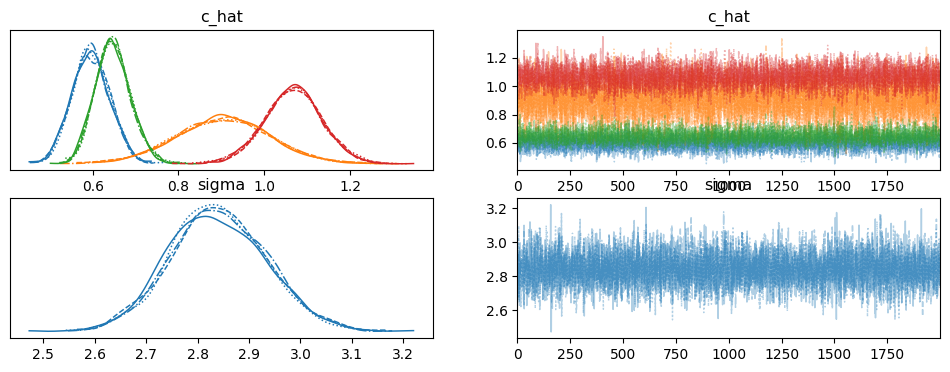

In [12]:
# Plot the trace of the posterior samples
az.plot_trace(idata, var_names=["c_hat", "sigma"])


c_hat/c:
[[0.6  0.91]
 [0.65 1.07]]

 [[0.67557518 0.43848517]
 [0.88461136 0.64786379]]


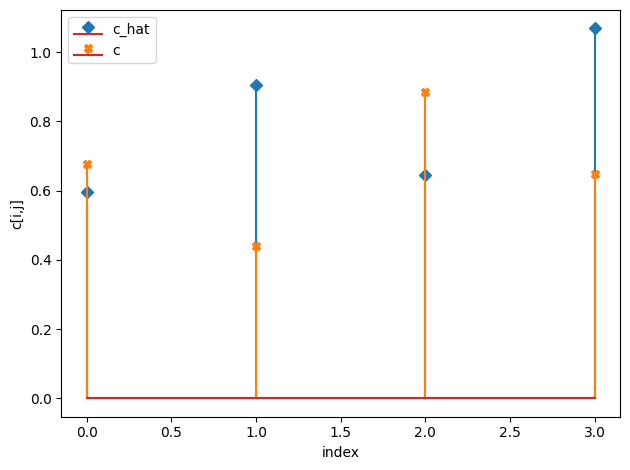

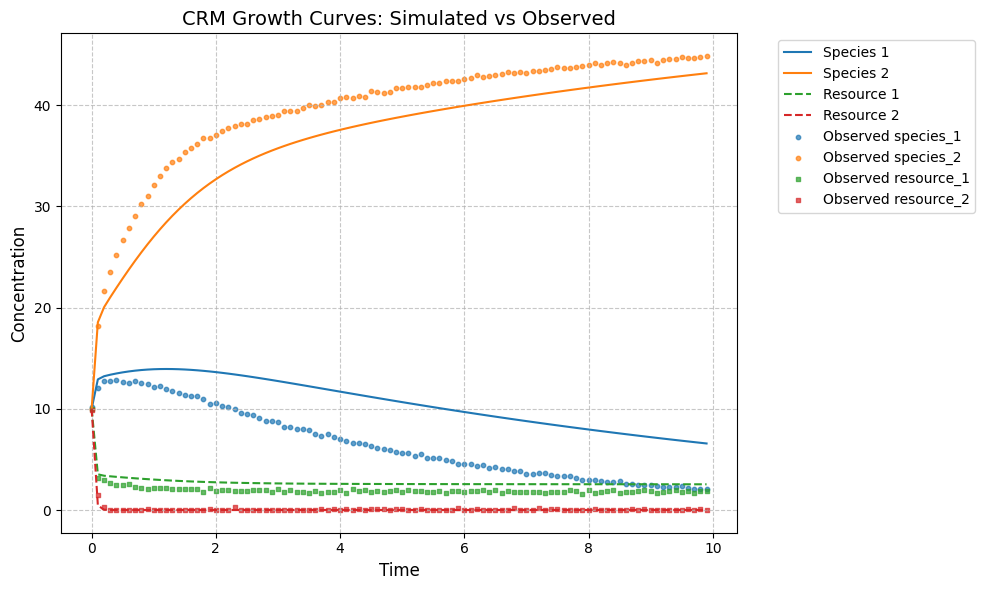

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [13]:
# Plot the CRM

init_species = 10 * np.ones(num_species+num_resources)

# inferred parameters
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1))

compare_params(c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau,
                         w = w,
                         c = c_h,
                         m = m,
                         r = r,
                         K = K)

#predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot predicted species and resouce dynamics against observed data

plot_CRM(observed_species, observed_resources, times, 'data-s2-r2.csv')

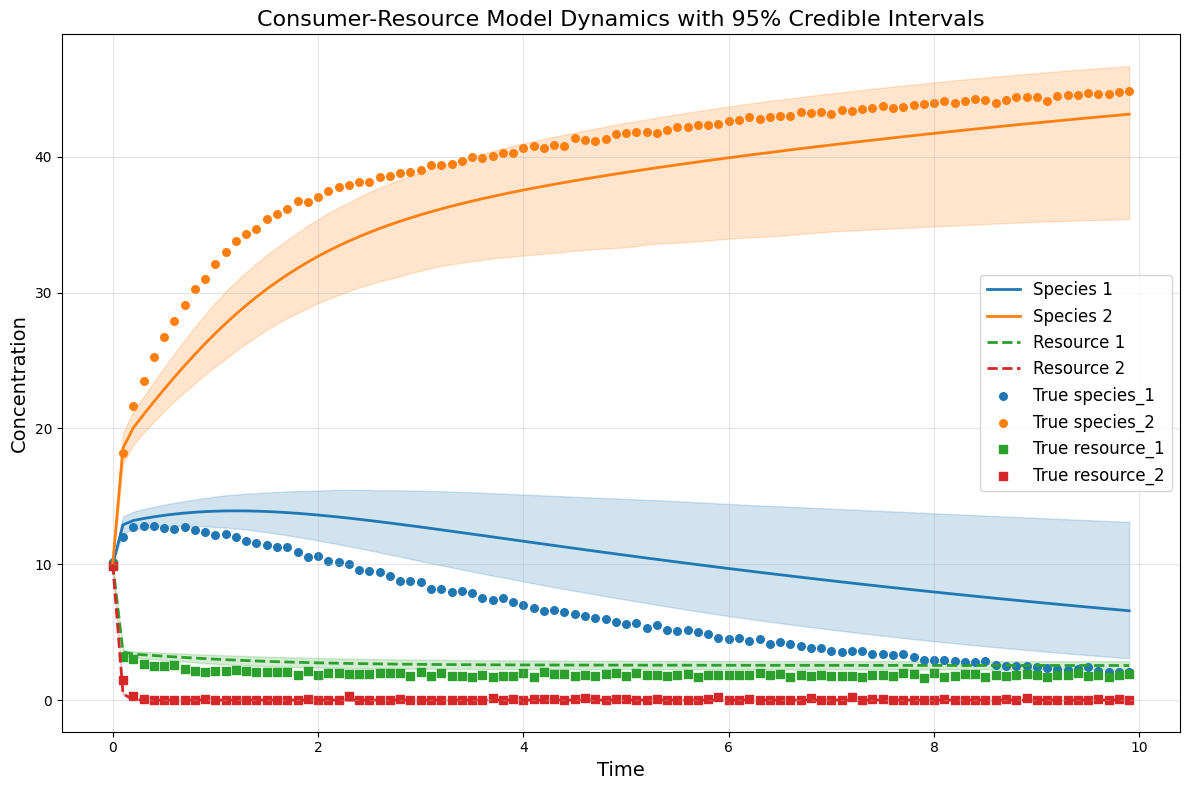

In [14]:
## Plot CRM  with confidence intervals

# Get posterior samples for c_hat 
c_posterior_samples = idata.posterior["c_hat"].values 

lower_percentile = 2.5
upper_percentile = 97.5

n_samples = 2000 
random_indices = np.random.choice(c_posterior_samples.shape[1], size=n_samples, replace=False)

# Store simulation results
all_species_trajectories = []
all_resource_trajectories = []

# Run simulations with different posterior samples
for i in range(n_samples):
    chain_idx = np.random.randint(0, c_posterior_samples.shape[0])
    c_sample = c_posterior_samples[chain_idx, random_indices[i]]
    
    sample_predictor = sim_CRM()
    sample_predictor.set_parameters(num_species=num_species,
                                   num_resources=num_resources,
                                   tau=tau,
                                   w=w,
                                   c=c_sample,
                                   m=m,
                                   r=r,
                                   K=K)
    
    sample_species, sample_resources = sample_predictor.simulate(times, init_species)
    
    # Store results
    all_species_trajectories.append(sample_species)
    all_resource_trajectories.append(sample_resources)

# Convert to numpy arrays
all_species_trajectories = np.array(all_species_trajectories)  
all_resource_trajectories = np.array(all_resource_trajectories)  

# Calculate percentiles across samples for each time point and species/resource
species_lower = np.percentile(all_species_trajectories, lower_percentile, axis=0)
species_upper = np.percentile(all_species_trajectories, upper_percentile, axis=0)
resource_lower = np.percentile(all_resource_trajectories, lower_percentile, axis=0)
resource_upper = np.percentile(all_resource_trajectories, upper_percentile, axis=0)


# plot the CRM with confidence intervals
plot_CRM_with_intervals(observed_species, observed_resources, 
                       species_lower, species_upper,
                       resource_lower, resource_upper,
                       times, 'data-s2-r2.csv')

## Infer all parameters

In [15]:
# read in pickled simulated parameters, tau, m, r, w, K and c
num_species = 2
num_resources = 2
with open("params-s2-r2.pkl", "rb") as f:
    params = pickle.load(f)
tau = params["tau"]
m = params["m"]
r = params["r"]
w = params["w"]
K = params["K"]
c = params["c"]

# read in the data

data = pd.read_csv("data-s2-r2.csv")

times = data.iloc[:, 0].values
yobs = data.iloc[:, 1:6].values



# Define priors
prior_tau_mean = 0.5   # species timescale vector
prior_tau_sigma = 0.2

prior_m_mean = 0.4     # mortality rate vector
prior_m_sigma = 0.2

prior_c_mean = 0.6     # resource preference matrix
prior_c_sigma = 0.2

prior_r_mean = 0.5      # resource timescale vector
prior_r_sigma = 0.2

prior_w_mean = 0.4     # resource quality vector
prior_w_sigma = 0.2

prior_K_mean = 3.0      # resource carrying capacity vector
prior_K_sigma = 2.0


# Sampling conditions
draws = 2000
tune = 2000
chains = 4
cores = 4

inference = inferCRMbayes()

inference.set_parameters(times=times, yobs=yobs, num_species=num_species, num_resources=num_resources,
                          prior_tau_mean=prior_tau_mean, prior_tau_sigma=prior_tau_sigma,
                          prior_m_mean=prior_m_mean, prior_m_sigma=prior_m_sigma,
                          prior_r_mean=prior_r_mean, prior_r_sigma=prior_r_sigma,
                          prior_w_mean=prior_w_mean, prior_w_sigma=prior_w_sigma,
                          prior_K_mean=prior_K_mean, prior_K_sigma=prior_K_sigma,
                          prior_c_mean=prior_c_mean, prior_c_sigma=prior_c_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


# To plot posterior distributions
#inference.plot_posterior(idata)

summary = az.summary(idata, var_names=["tau_hat", "w_hat", "c_hat", "m_hat", "r_hat", "K_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



times shape: (100,)
yobs shape: (100, 4)
Number of species: 2
Number of resources: 2
tau_hat is inferred
w_hat is inferred
c_hat is inferred
m_hat is inferred
r_hat is inferred
K_hat is inferred


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau_hat, w_hat, c_hat_vals, m_hat, r_hat, K_hat]


Output()

/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+00


/home/cclare/projects/CRM/MIMIC/MIMIC_env/lib/python3.10/site-packages/pymc/ode/ode.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 153967 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


              mean     sd  r_hat
tau_hat[0]   0.141  0.037    1.0
tau_hat[1]   0.106  0.006    1.0
w_hat[0]     0.610  0.135    1.0
w_hat[1]     1.240  0.141    1.0
c_hat[0, 0]  0.217  0.055    1.0
c_hat[0, 1]  0.576  0.107    1.0
c_hat[1, 0]  0.205  0.037    1.0
c_hat[1, 1]  0.489  0.068    1.0
m_hat[0]     0.292  0.072    1.0
m_hat[1]     0.248  0.048    1.0
r_hat[0]     0.109  0.009    1.0
r_hat[1]     0.102  0.002    1.0
K_hat[0]     3.718  0.577    1.0
K_hat[1]     6.551  1.392    1.0
sigma[0]     1.720  0.063    1.0


'model_posterior.nc'

Plotting posterior for tau_hat


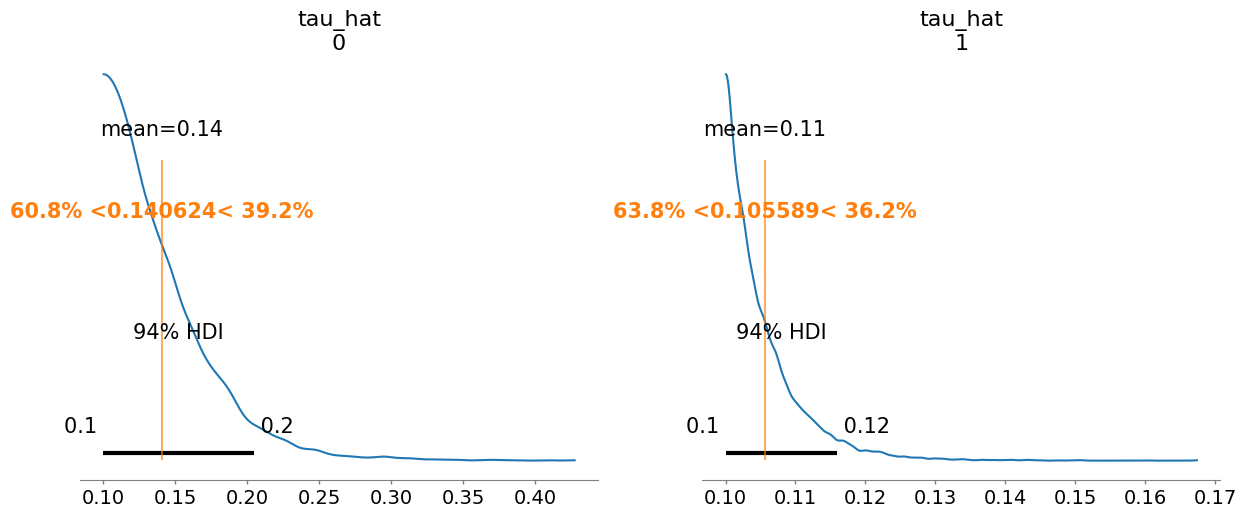

Plotting posterior for w_hat


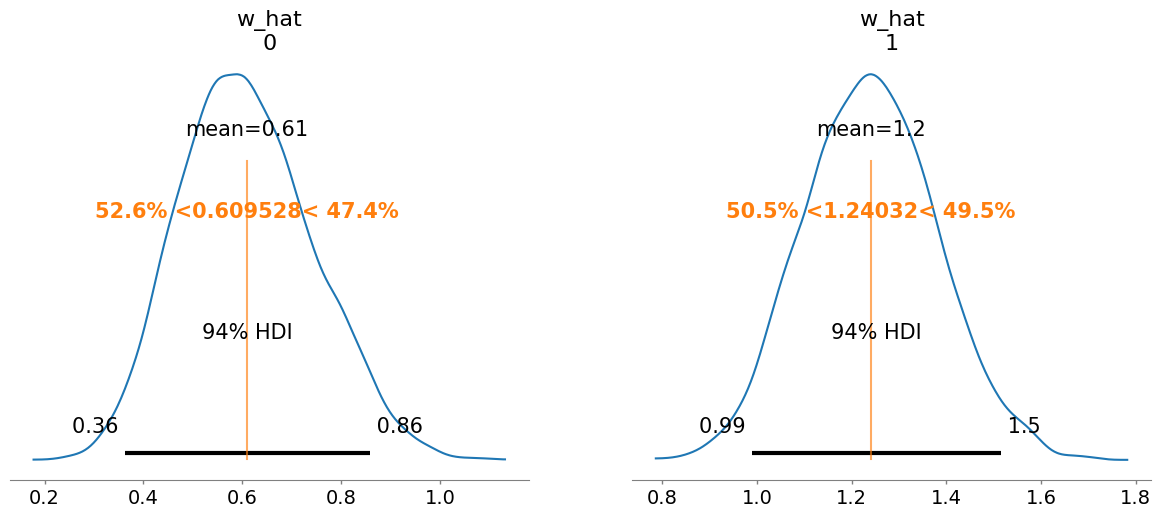

Plotting posterior for c_hat


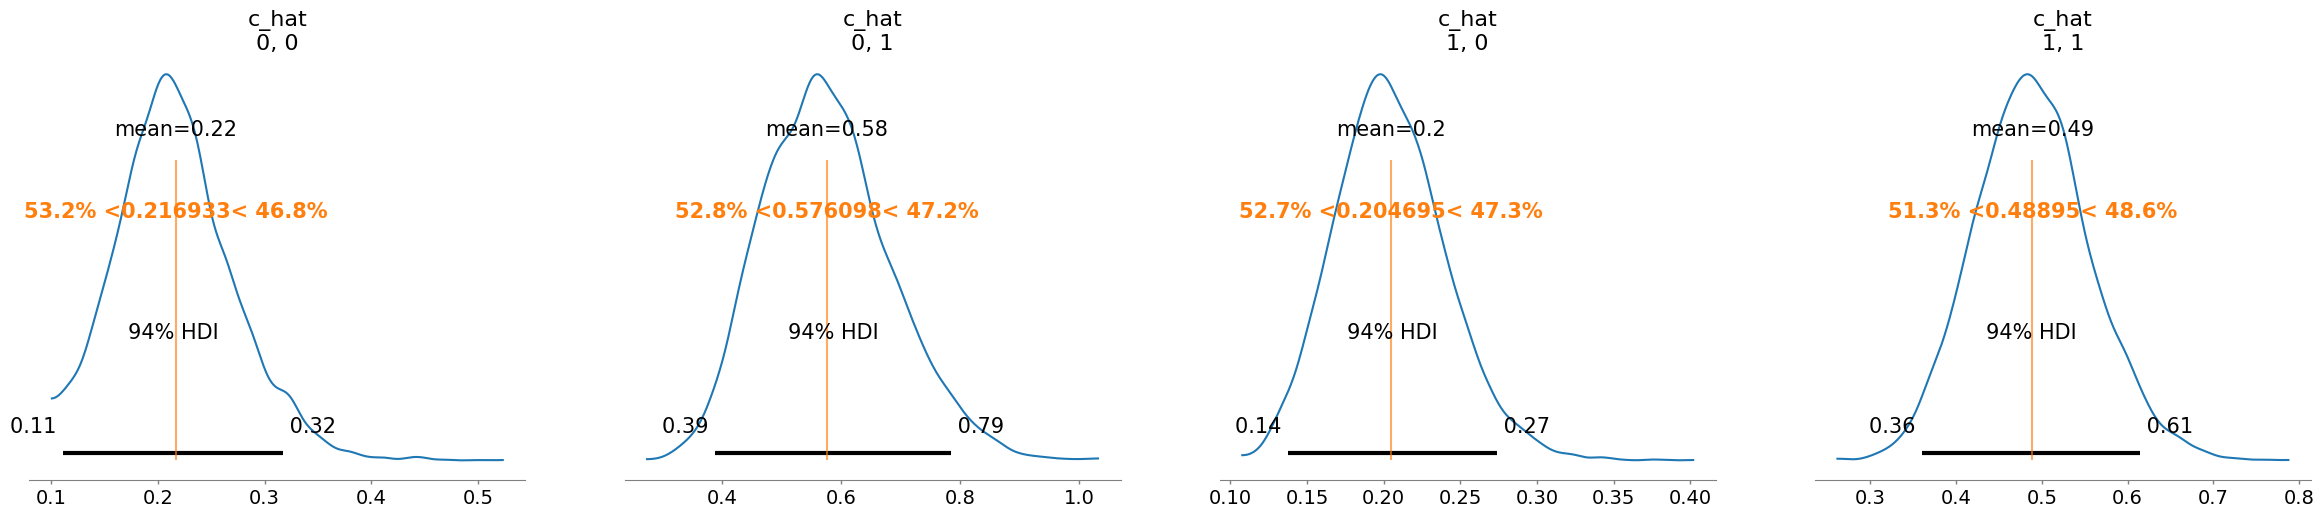

Plotting posterior for m_hat


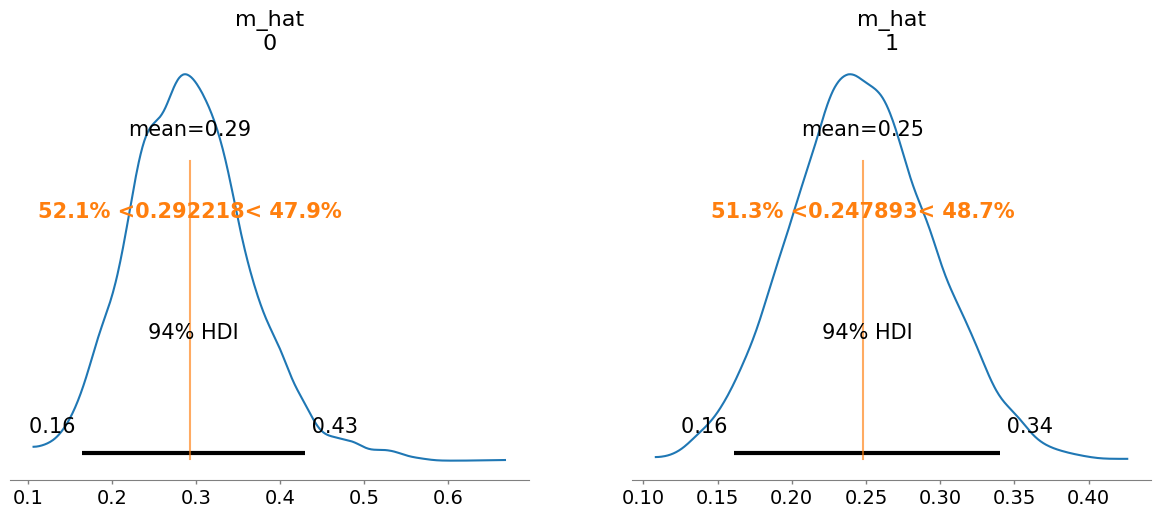

Plotting posterior for r_hat


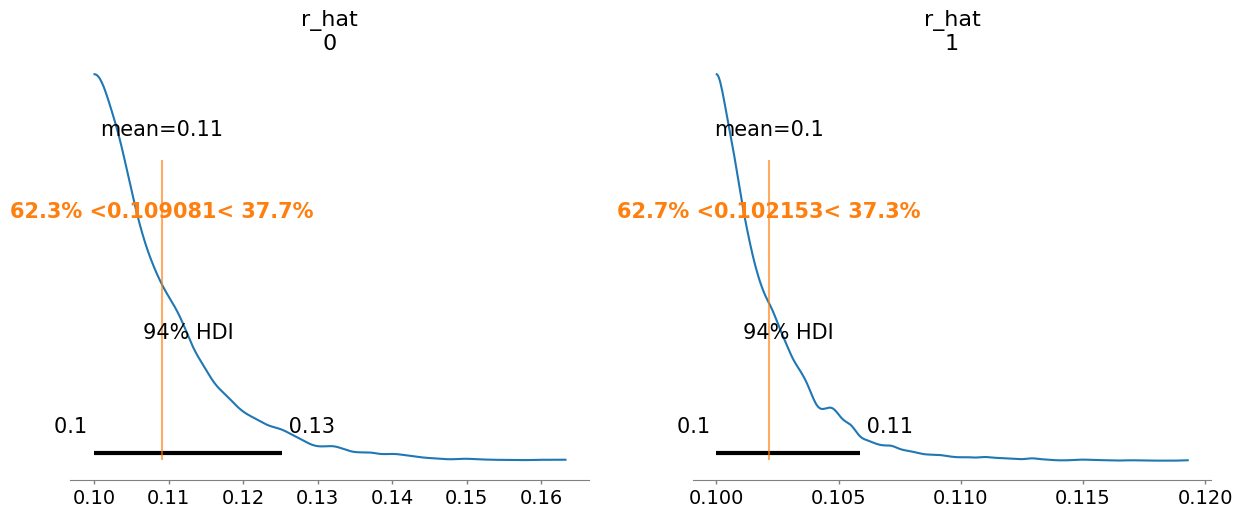

Plotting posterior for K_hat


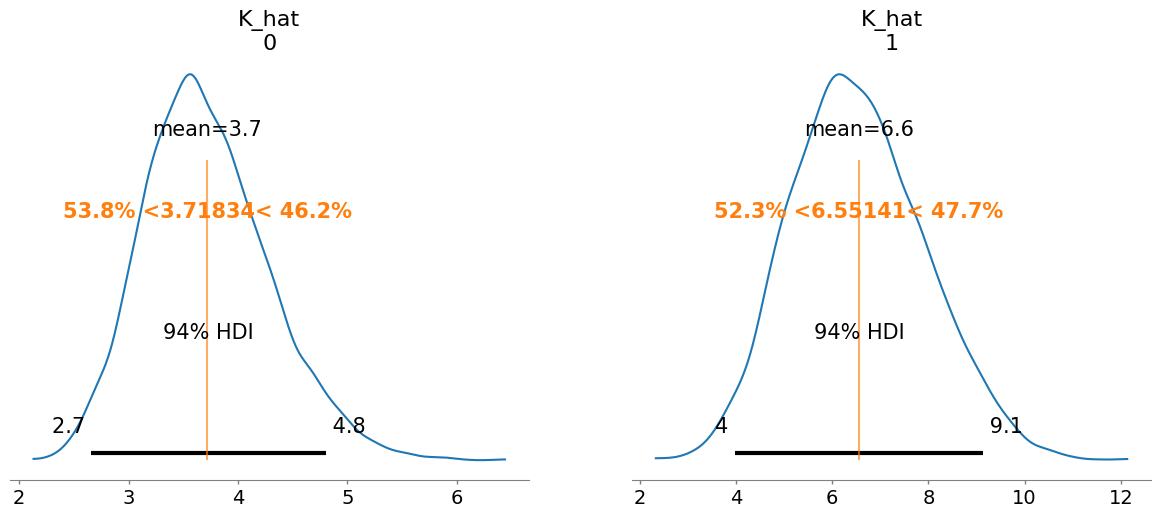

In [16]:
# To plot posterior distributions
inference.plot_posterior(idata)


tau_hat/tau:
[0.13 0.1 ]

 [0.65717535 0.32891147]


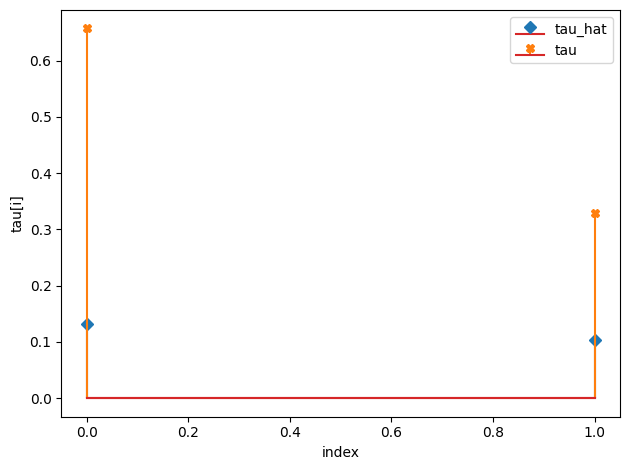


m_hat/m:
[0.29 0.25]

 [0.49237276 0.45684701]


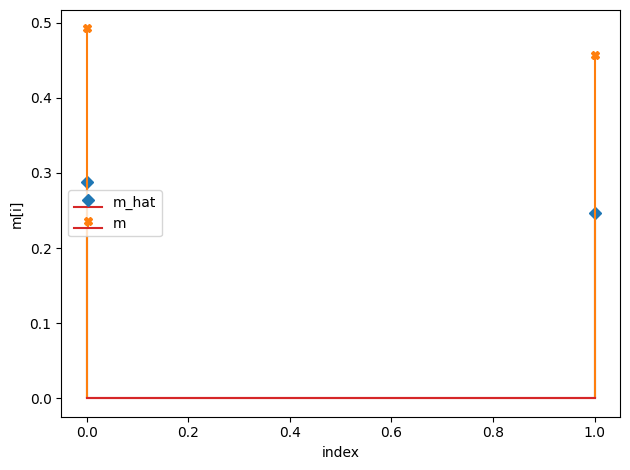


r_hat/r:
[0.11 0.1 ]

 [0.37454241 0.68323977]


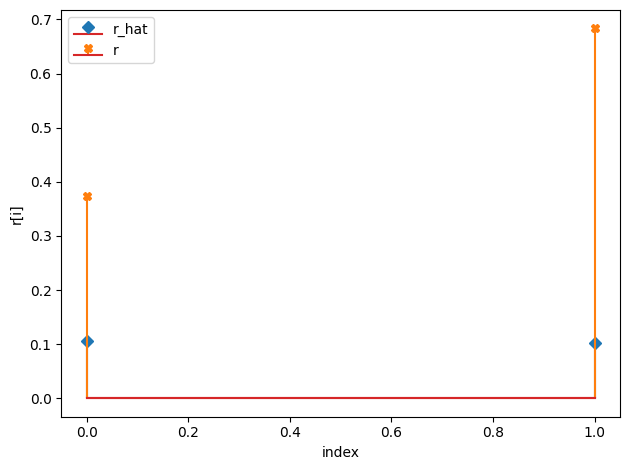


w_hat/w:
[0.6  1.24]

 [0.28148116 0.54105182]


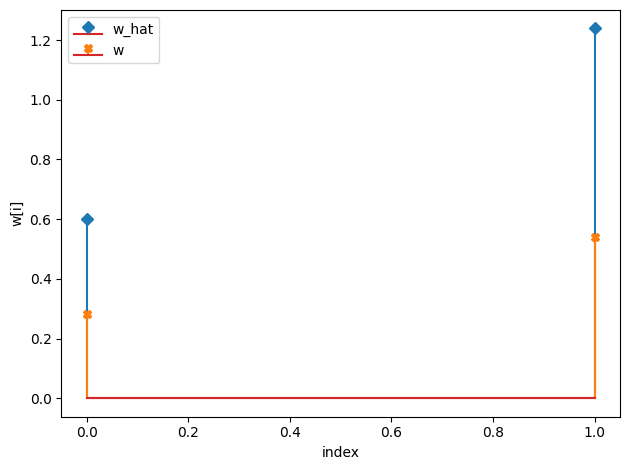


K_hat/K:
[3.67 6.47]

 [4.9471502  1.53710107]


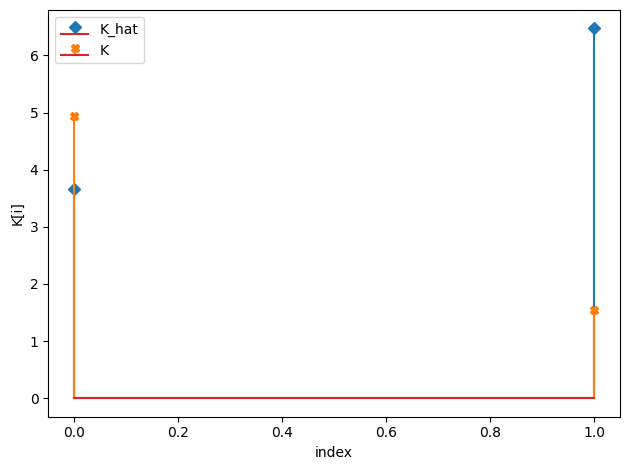


c_hat/c:
[[0.21 0.57]
 [0.2  0.49]]

 [[0.67557518 0.43848517]
 [0.88461136 0.64786379]]


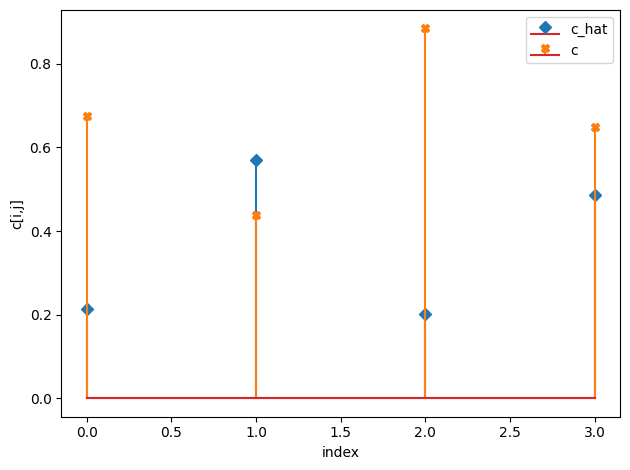

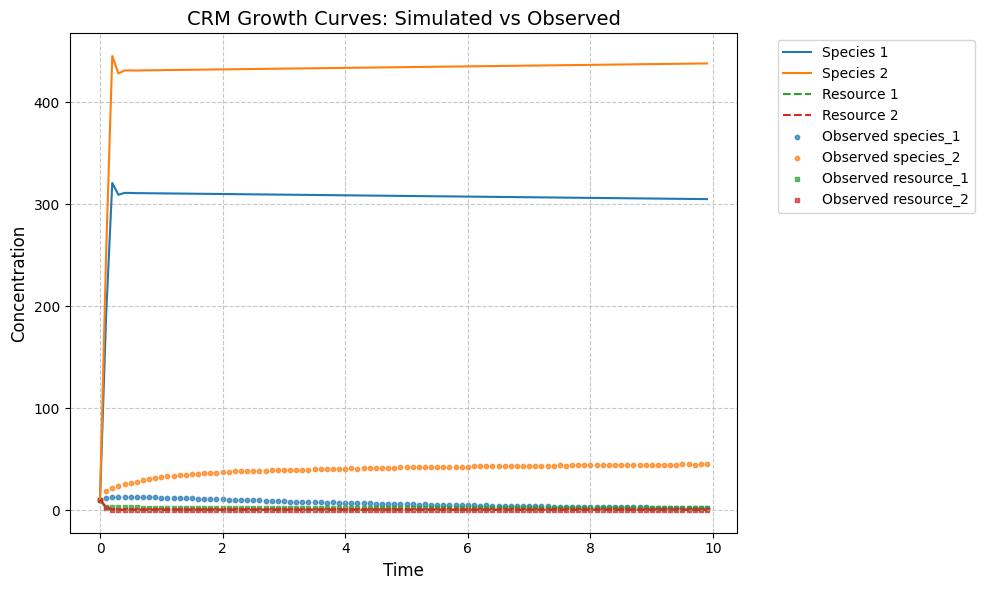

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'CRM Growth Curves: Simulated vs Observed'}, xlabel='Time', ylabel='Concentration'>)

In [17]:

init_species = 10 * np.ones(num_species+num_resources)

# # compare fitted with simulated parameters
tau_h = np.median(idata.posterior["tau_hat"].values, axis=(0,1) ).reshape(-1)
m_h = np.median(idata.posterior["m_hat"].values, axis=(0,1) ).reshape(-1)
r_h = np.median(idata.posterior["r_hat"].values, axis=(0,1) ).reshape(-1)
w_h = np.median(idata.posterior["w_hat"].values, axis=(0,1) ).reshape(-1)
K_h = np.median(idata.posterior["K_hat"].values, axis=(0,1) ).reshape(-1)
c_h = np.median(idata.posterior["c_hat"].values, axis=(0,1) )


compare_params(tau=(tau, tau_h), m=(m, m_h), r=(r, r_h), w=(w, w_h), K=(K, K_h) , c=(c, c_h))

predictor = sim_CRM()

predictor.set_parameters(num_species = num_species,
                         num_resources = num_resources,
                         tau = tau_h,
                         w = w_h,
                         c = c_h,
                         m = m_h,
                         r = r_h,
                         K = K_h)

predictor.print_parameters()

observed_species, observed_resources = predictor.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot simulated species and resouce dynamics

plot_CRM(observed_species, observed_resources, times, 'data-s2-r2.csv')
